In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
import simulator_BC_evidences as sim_bc_e
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.best_batch import BestBatchSampler
from black_it.loss_functions.msm import MethodOfMomentsLoss
from msm_first_moments import MethodOfMomentsLoss_4Moments, MethodOfMomentsLoss_9Moments
from black_it.samplers.random_uniform import RandomUniformSampler
from typing import Sequence
import os
import contextlib
from scipy.special import expit
import torch
import importlib
from tqdm import tqdm
from time import time
import calibration_simple_BC as cal_bc
import simulator_BC_coo as sim_coo
from scipy.special import expit as sigmoid

In [43]:
class BC_simulator_hidden_mu_X0():
    def __init__(self, edges, N, real_mu, real_epsilon, rho = 70, seed = 1):
        self.N = N
        self.edges = edges.clone().long()
        _, edge_per_t, _ = edges.shape
        self.real_mu = real_mu
        self.real_epsilon = real_epsilon
        self.rho = rho
        self.seed = seed
        self.mean_s = np.atleast_2d(edges[:,:,2].sum(dim = 1) / edge_per_t).T
    
    def simulate_mean_s(self, theta, N = 200, seed = None):
        epsilon, mu = theta
        X = torch.rand(self.N)
        
        mean_s_pred = []
        
        
        if seed != None:
            np.random.seed(self.seed)
        
        X0, _, _ = sim_coo.intialize_simulator(None, self.N, [])
        X_t = X0.copy()
        diff_X = X0[:,None] - X0[None,:]
        
        T, edge_per_t, _ = self.edges.size()
        
        for t in range(T):
            u,v,s_obs = self.edges[t].T
            
            s_pred = (np.random.random(edge_per_t) < sigmoid(self.rho * (epsilon - np.abs(diff_X[u,v])))) + 0.
            new_X_t, diff_X = sim_coo.opinion_update(diff_X, X_t, u, v, s_pred, self.N, mu)
            
            X_t = new_X_t.copy()
            
            mean_s_pred.append(s_pred.mean())
            
            X_t  = np.clip(X_t, 10e-5, 1 - 10e-5)
        return np.atleast_2d(mean_s_pred).T

def calibrate_epsilon_BC_hidden_mu_X0(simulator, plot_loss = True, calibration_batches = 100, ensemble_size = 3,
                                   sampler = HaltonSampler, loss = MethodOfMomentsLoss(), batch_size = 1, compare_all_s = False,
                                   parameters_bounds = [[0., 0.], [0.5, 1.]], precisions = [0.0001, 0.01], return_time = False):
    
    t0 = time()
    model = simulator.simulate_mean_s
    real_data = simulator.mean_s
    
    samplers = [sampler(batch_size)]


    BC_cal = Calibrator(real_data = real_data,
                        samplers = samplers,
                        loss_function = loss,
                        model = model,
                        parameters_bounds = parameters_bounds,
                        parameters_precision = precisions,
                        ensemble_size = ensemble_size,
                        saving_folder = None,
                        verbose = False,
                        n_jobs = 1#'initial_state'
                       )
    
    
    params, losses = BC_cal.calibrate(calibration_batches)
    epsilon_sim, mu_sim = params.T
    
    loss_df = pd.DataFrame({"epsilon": epsilon_sim, "mu": mu_sim, "loss": losses}).sort_values("loss")
    
    

    estimated_epsilon, estimated_mu, _ = loss_df.iloc[0]
    t1 = time()
    calibration = {"loss": loss_df, "estimation": (estimated_epsilon, estimated_mu)}
    
    if return_time:
        calibration["time"] = t1-t0
    
    return calibration


In [44]:
N, T, edge_per_t = 100, 100, 1
epsilon, mu = 0.2, 0.2

calibration_batches = 100


X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)

simulator = BC_simulator_hidden_mu_X0(edges, N, mu, epsilon, rho = 70)


calibrated_epsilon = calibrate_epsilon_BC_hidden_mu_X0(simulator, calibration_batches = calibration_batches,
                                                      loss = MethodOfMomentsLoss_9Moments(),
                                                      ensemble_size = 1, return_time = True)


<AxesSubplot:xlabel='epsilon', ylabel='loss'>

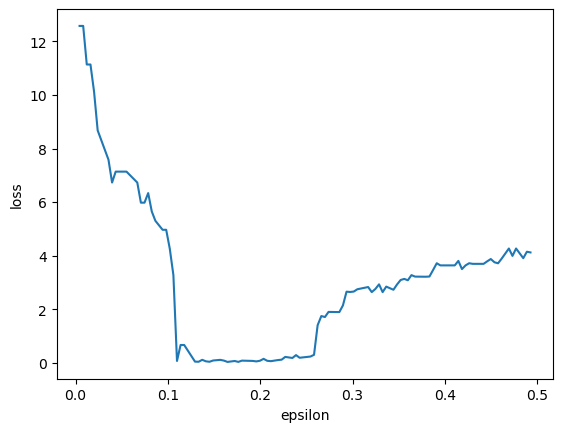

In [45]:
sns.lineplot(data = calibrated_epsilon["loss"], x = "epsilon", y = "loss")

In [57]:
def repeat_simulations_random(tot_simulations, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                              ensemble_size_list, calibration_batches_list, sum_ab_list, evidences_per_t_list,
                              verbose = True):
    
    simulations = []
    for _ in tqdm(range(tot_simulations), disable = not verbose):
        np.random.seed(_ + 40)
        T, N, edge_per_t, epsilon, mu, ensemble_size,\
        calibration_batches, sum_ab, evidences_per_t = np.random.choice(T_list), np.random.choice(N_list),\
        np.random.choice(edge_per_t_list), np.random.choice(epsilon_list), np.random.choice(mu_list),\
        np.random.choice(ensemble_size_list), np.random.choice(calibration_batches_list),\
        np.random.choice(sum_ab_list), np.random.choice(evidences_per_t_list)
        
        X, edges = sim_coo.simulator_BC_np_coo(N, T, edge_per_t, epsilon, mu, with_evidences = False, rho = 70)
        
        simulator = BC_simulator_hidden_mu_X0(edges, N, mu, epsilon, rho = 70)
        
        
        calibrated_epsilon = calibrate_epsilon_BC_hidden_mu_X0(simulator, calibration_batches = calibration_batches,
                                                            loss = MethodOfMomentsLoss_4Moments(),
                                                            ensemble_size = 1, return_time = True)

        
        _, (epsilon_sim, mu_sim), time_sim = calibrated_epsilon.values()
        
        
        simulations.append([epsilon_sim, np.abs(epsilon - epsilon_sim),mu_sim, np.abs(mu - mu_sim),\
                            time_sim, epsilon, mu, T, N, edge_per_t, ensemble_size,\
                            calibration_batches])
        
                    
    return pd.DataFrame(simulations, columns = ["epsilon", "distance_epsilon", "mu", "distance_mu",\
                            "time", "real_epsilon", "real_mu", "T", "N", "edge_per_t", "ensemble_size",\
                            "calibration_batches"])

In [60]:
T_list = [100] 
N_list = [100]
edge_per_t_list = [1,4,8,16]
epsilon_list = np.arange(0.01, 0.49, 0.04) 
mu_list = np.arange(0.04, 0.99, 0.08)
ensemble_size_list = [1]
calibration_batches_list = [200]
evidences_per_t_list = [5,10,20,40]
sum_ab_list = [0.1, 1, 10]



calibrations_df_fixed = repeat_simulations_random(400, T_list, N_list, edge_per_t_list, epsilon_list, mu_list,
                                                  ensemble_size_list, calibration_batches_list,
                                                  sum_ab_list, evidences_per_t_list, 
                                                  verbose = True)


  1%|▌                                                                  | 3/400 [00:35<1:17:54, 11.78s/it]/home/jacopo.lenti/miniconda3/envs/learning-od-step-by-step/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
100%|█████████████████████████████████████████████████████████████████| 400/400 [1:39:49<00:00, 14.97s/it]


In [77]:
#calibrations_df_fixed.to_csv("../data/calibrations_hidden_mu_X0_230619.csv")
calibrations_df_fixed = pd.read_csv("../data/calibrations_hidden_mu_X0_230619.csv", index_col = 0)

In [84]:
#calibrations_df_fixed = calibrations_df_fixed.rename(columns = {"epsilon": "params", "distance_epsilon": "distances"})\
#.assign(epsilon = lambda x: [u[0] for u in x["params"]],
#        mu = lambda x: [u[1] for u in x["params"]],
#        distance_epsilon = lambda x: [u[0] for u in x["distances"]],
#        distance_mu = lambda x: [u[1] for u in x["distances"]]
#       ).drop(["params", "distances"], axis = 1)"""

calibrations_df_fixed.sort_values("distance_epsilon", ascending = False).head(13)

,epsilon,distance_epsilon,mu,distance_mu,time,real_epsilon,real_mu,T,N,edge_per_t,ensemble_size,calibration_batches
68,0.4932,0.2032,0.97,0.85,25.674859,0.29,0.12,100,100,16,1,200
17,0.4354,0.1854,0.94,0.50,17.146499,0.25,0.44,100,100,16,1,200
249,0.3038,0.1338,0.95,0.75,12.889267,0.17,0.20,100,100,16,1,200
247,0.3182,0.1318,0.74,0.18,13.175302,0.45,0.92,100,100,16,1,200
372,0.3416,0.1316,0.84,0.64,14.254174,0.21,0.20,100,100,8,1,200
253,0.1683,0.1217,0.22,0.14,13.493742,0.29,0.36,100,100,8,1,200
33,0.2088,0.1188,0.49,0.35,12.432363,0.09,0.84,100,100,8,1,200
360,0.4880,0.1180,0.30,0.02,8.016997,0.37,0.28,100,100,1,1,200
357,0.0532,0.1168,0.73,0.11,12.171659,0.17,0.84,100,100,16,1,200
84,0.1657,0.1157,0.70,0.10,19.554155,0.05,0.60,100,100,8,1,200


In [67]:
calibrations_df_fixed[["time", "distance_epsilon", "distance_mu"]].mean()

time                14.924549
distance_epsilon     0.033441
distance_mu          0.303400
dtype: float64

<AxesSubplot:ylabel='distance_mu'>

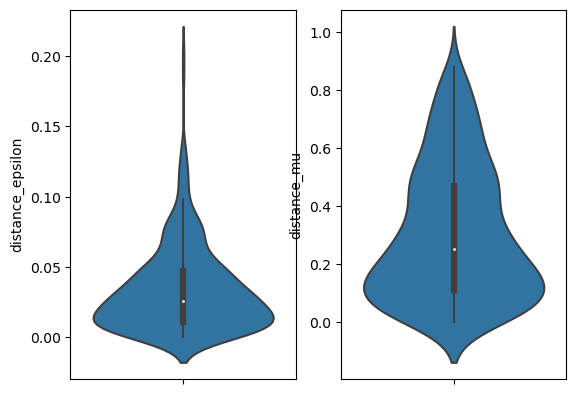

In [68]:
fig, axes = plt.subplots(ncols = 2)
sns.violinplot(y = calibrations_df_fixed["distance_epsilon"], ax = axes[0])
sns.violinplot(y = calibrations_df_fixed["distance_mu"], ax = axes[1])

<AxesSubplot:xlabel='edge_per_t', ylabel='distance_epsilon'>

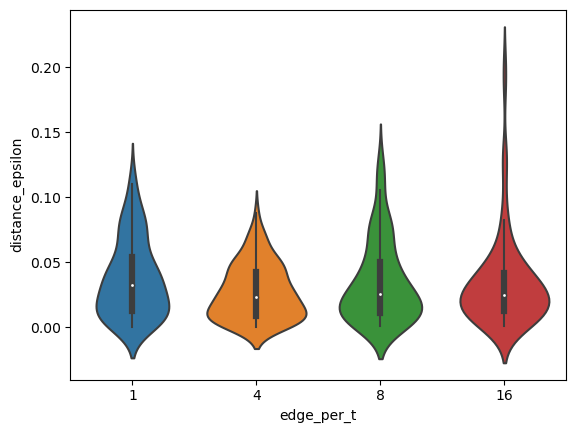

In [72]:
fig, axes = plt.subplots()

sns.violinplot(data = calibrations_df_fixed, x = "edge_per_t", y = "distance_epsilon", ax = axes)

In [83]:
calibrations_df_fixed.groupby("edge_per_t").mean()["distance_epsilon"]

edge_per_t
1     0.037326
4     0.027244
8     0.035096
16    0.033734
Name: distance_epsilon, dtype: float64